<a href="https://colab.research.google.com/github/iabiala/Machine-Learning-projects/blob/main/PPO_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstration of using PyTorch and torchrl.

This practice shows how to train a parametric policy network to solve the Inverted Pendulum task from the OpenAI-Gym control library.
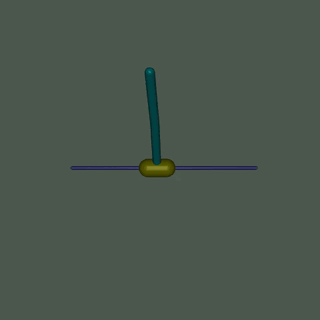


This shows how to

*   Create an environment in TorchRL, transform its outputs, and collect data from its environment
*   How to make your classes talk to each other using `TensorDict`



*   The basics of building your training loop with TorchRL: How to compute the advantage signal for policy gradient methods; How to create a stochastic policy using a probabilistic neural network; How to create a dynamic replay buffer and sample from it without repetition.









In [38]:
!pip3 install torchrl

!pip3 install tqdm
!pip install mujoco

Proximal Policy Optimization (PPO) is a policy-gradient algorithm where a batch of data is being collected and directly consumed to train the policy to maximise the expected return given some proximality constraints.



In [4]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing

from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter, TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

**Define Hyperparameters**

Depending on the resources available, one may choose to execute the policy on GPU or on another device.

In [5]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

**Data Collection Parameters**


When collecting data, we will be able to define how big each batch will be by defining a `frames_per_batch` parameter.


In [6]:
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 50_000

**PPO Parameters**

At each data collection, we will run the optimization over a certain number of epochs, each time consuming the entire data we just acquired in a nested training loop.

By collecting a large batch of frames (trajectories) before updating the policy, PPO ensures that the neural network learns from a varied, stable, and statistically significant sample of experience, rather than reacting excessively to individual, high-variance episodes.

In [7]:
sub_batch_size = 64   # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10 # optimizaiton steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

**Define an environment**

In [11]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**Transforms**

TRansform wrappers allows us to append transforms to our environments to prepare the data for the policy which is usually done using `TransformedEnv` instance.

In [14]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [15]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: Composite(
    observation: UnboundedContinuous(
        shape=torch.Size([11]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
        device=cpu,
        dtype=torch.int64,
        domain=discrete),
    device=cpu,
    shape=torch.Size([]),
    data_cls=None)
reward_spec: UnboundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),

In [16]:
# Compares its output against the environment specs
check_env_specs(env)

2026-02-16 17:04:34,977 [torchrl][INFO]    check_env_specs succeeded! [END]


Typically, at each step, an RL environment receives an action as input, and outputs an observation, a reward and a done state. The observation may be composite, meaning that it could be composed of more than one tensor. This is not a problem for TorchRL, since the whole set of observations is automatically packed in the output `TensorDict`. After executing a rollout (for example, a sequence of environment steps and random action generations) over a given number of steps, we will retrieve a `TensorDict` instance with a shape that matches this trajectory length:

In [18]:
rollout = env.rollout(6)
print("rollout of three steps", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps TensorDict(
    fields={
        action: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([6, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([6, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([6]),
            devic

**Policy**

It utilizes a stochastic policy to handle exploration. This means our neural network will have to output the parameters of a distribution, rather than a single value corresponding to the action taken.

We use Tanh-normal distribution to respect the action space boundaries. TorchRL provides such distribution, and the only thing we need to care about is to build a neural network that outputs the right number of parameters for the policy to work with (a location, or mean, and a scale):

In [20]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

To enable the policy to 'talk' with the environment through the `tensordict` data carrier, we wrap the `nn.Module` in a `TensorDictModule`

In [22]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

Now, we need to build a distribution out of the location and scale of our normal distribution. To do so, we instruct `ProbabilisticActor` class to build a `TanhNormal` out of the location and scale parameters.

In [24]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
    # we will need the log-prob for the numerator of the importance weights
)

**Value Network**

The value network is a crucial component of the PPO algorithm, even though it won’t be used at inference time. This module will read the observations and return an estimation of the discounted return for the following trajectory. This allows us to amortize learning by relying on the some utility estimation that is learned on-the-fly during training. Our value network share the same structure as the policy, but for simplicity we assign it its own set of parameters.

In [26]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [27]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        action_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running v

**Data Collector**

TorchRL provides a set of DataCollector classes. Briefly, these classes execute three operations: reset an environment, compute an action given the latest observation, execute a step in the environment, and repeat the last two steps until the environment signals a stop (or reaches a done state).

They allow you to control how many frames to collect at each iteration (through the `frames_per_batch` parameter), when to reset the environment (through the `max_frames_per_traj` argument), on which `device` the policy should be executed, etc. They are also designed to work efficiently with batched and multiprocessed environments.

The simplest data collector is the `SyncDataCollector`: it is an iterator that you can use to get batches of data of a given length, and that will stop once a total number of frames (`total_frames`) have been collected. Other data collectors (`MultiSyncDataCollector` and `MultiaSyncDataCollector`) will execute the same operations in synchronous and asynchronous manner over a set of multiprocessed workers.

As for the policy and environment before, the data collector will return TensorDict instances with a total number of elements that will match frames_per_batch. Using TensorDict to pass data to the training loop allows you to write data loading pipelines that are 100% oblivious to the actual specificities of the rollout content.

In [28]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

/usr/local/lib/python3.12/dist-packages/torchrl/collectors/_base.py:1045: DeprecationWarning: SyncDataCollector has been deprecated and will be removed in v0.13. Please use Collector instead.
  warnings.warn(


**Replay Buffer**

Replay buffers are a common building piece of off-policy RL algorithms. In on-policy contexts, a replay buffer is refilled every time a batch of data is collected, and its data is repeatedly consumed for a certain number of epochs.

TorchRL’s replay buffers are built using a common container `ReplayBuffer` which takes as argument the components of the buffer: a storage, a writer, a sampler and possibly some transforms. Only the storage (which indicates the replay buffer capacity) is mandatory. We also specify a sampler without repetition to avoid sampling multiple times the same item in one epoch. Using a replay buffer for PPO is not mandatory and we could simply sample the sub-batches from the collected batch, but using these classes make it easy for us to build the inner training loop in a reproducible way.

In [30]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

**Loss Function**

The PPO loss can be directly imported from TorchRL for convenience using the `ClipPPOLoss` class. This is the easiest way of utilizing PPO: it hides away the mathematical operations of PPO and the control flow that goes with it.

In [34]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True, device=device
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff= entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

**Training Loop**

In [35]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

  0%|          | 0/50000 [00:00<?, ?it/s]

2026-02-16 18:13:22,191 [torchrl][INFO]    Initialized LazyTensorStorage with torch.Size([1000]) shape [END]


eval cumulative reward:  250.8970 (init:  241.1877), eval step-count: 26, average reward= 9.3172 (init= 9.0985), step count (max): 96, lr policy:  0.0000: 100%|██████████| 50000/50000 [04:55<00:00, 178.49it/s] 

**Results**

Before the 1M step cap is reached, the algorithm should have reached a max step count of 1000 steps, which is the maximum number of steps before the trajectory is truncated.

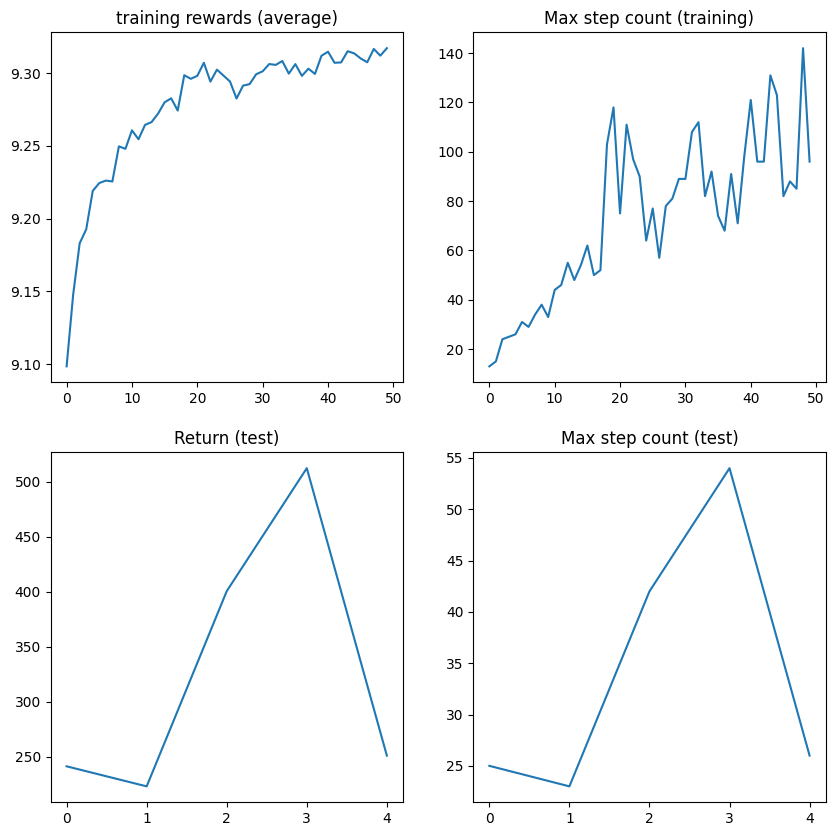

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()